<h1>CS180 MP1</h1>

<h2>Imported libraries</h2>

In [1]:
#Imported libraries
#import math
import time
import heapq
import matplotlib.patches
from shapely.geometry import Point, Polygon, LinearRing
from matplotlib import pyplot as plt

<h2>Miscellaneous Functions</h2>

In [2]:
#Functions

#Obtain input file name from user or as a parameter to the function, returns text from entire file, ensure input file is in same directory
def fileInput():
    fileName = input("Input filename: ")
    f = open(fileName, 'r')
    fileTxt = f.read()
    f.close()
    return fileTxt

#Turns a string of "(x,y)" into a tuple of (x,y)
def textToTuple(text):
    text = text.replace("(","")
    text = text.replace(")","")
    text = text.replace("\n","")
    text = text.split(",")
    # print(text)
    return ((int(text[0]),int(text[1])))

<h1>Input and Parsing</h1>

<p>The Input function takes in the fileTxt and parses it to obtain the Start Position, the Goal Positon and the Polygon vertices.</p>
<p>The function returns an input array of tuples where input[0] is the start position, input[1] is the goal positon, and the remaining entries are arrays of vertices for each polygon</p>

In [3]:
def Input(fileTxt):

    #Divide input text by line
    fileTxt = fileTxt.split('\n')

    #First line is start pos
    startPos = textToTuple(fileTxt.pop(0))

    #Next line is goal pos
    goalPos = textToTuple(fileTxt.pop(0))

    #Remove potential empty lines from of list
    i = 0
    for t in fileTxt:
        if (t == ""):
            fileTxt.pop(i)
        i = i + 1
    
    #Obtain polygon vertices
    polygons = []
    i = 0
    for p in fileTxt:
        p = p.replace("(","")
        p = p.replace(")","")
        p = p.split(",")
        k = 0
        vertices = []
        while(k*2 < len(p)):
            vertices.append((int(p[2*k]),int(p[2*k+1])))
            k = k + 1
        polygons.append(vertices)
        i = i + 1

    #Print inputs
    print("Start Position: " + str(startPos))
    print("Goal Position: " + str(goalPos))
    i = 1
    for p in polygons:
        print("Polygon " + str(i) + " vertices: " + str(p))
        i = i + 1

    inputs = []
    inputs.append(startPos)
    inputs.append(goalPos)
    for p in polygons:
        inputs.append(p)

    return inputs

<h1>Uninformed Search Related Functions</h1>
<p>Functions used in conjunction with BFS and DFS</p>

<h2>initMapUninformed</h2>
<p>initMapUninformed initializes a 100x200 array and sets each value to 0, indicating that all spaces are unvisited</p>

In [4]:
def initMapUninformed(polygons, outlines):
    map = [[] for i in range(200)]

    #List all values for map as 0, meaning they have not been visited yet or -1 if they are inside a polygon
    for i in range (200):
        for j in range(100):
            map[i].append(0)
            p = Point([i,j])
            for polygon in polygons:
                if(p.within(polygon)):
                    map[i][j] = -1
            for outline in outlines:
                if(p.within(outline)):
                    map[i][j] = -1

    return map

<h2>getPathUninformed</h2>
<p>For both the BFS and DFS implementation in this program, each visited node in the 100x200 array is given the position of its parent node, that is, the node that was expanded before the visited node was visited. This function makes use of that to obtain the path. This function starts at the goal position and inspects its value to obtain its parent node, whose position is inserted at the start of the path array. The function then goes to the parent node to obtain the position of the 'grandparent' node and again inserts it into the path array. The function loops this until it arrives at the start node. It then returns the path array.</p>

In [5]:
def getPathUninformed(S,G,map):
    path = []
    path.append(G)
    p = G
    while(path[0] != S):
        p = (map[p[0]][p[1]])
        path.insert(0,p)

    return path

<h1>Informed Search Related Functions and Classes</h1>
<p>Functions used in conjunction with A*</p>

<h2>map_node</h2>
<p>Each point on the map must be able to store the following:</p>
<ul>
    <li>h - heuristic value</li>
    <li>g - current cost, for computing f of discovered nodes</li>
    <li>f - set to g + h, total A* cost of node</li>
    <li>x, y - the coordinates of the point</li>
    <li>pred_horizontal, pred_up_right - two booleans that indicate the relative direction of the point's path predecessor</li>
    <li>time - a tuple (step_number, order) that stores the point's order of entry into the heap</li>
    <li>is_discovered - a boolean initially set to False, becomes True once the point is visited once. This is used later in conditional logic to prevent access of uninitialized properties.</li>
    <li>is_expanded - a boolean initially set to False, becomes True once the point is expanded. After this the object must not be altered any further.</li>
    <li>is_valid - a boolean initially set to True. If a point is inside a polygon or outside the bounds or the area, this should be set to False.</li>
</ul>

In [6]:
class map_node:
    # properties: h, g, f, x, y, pred_horizontal, pred_up_right, time(step, order), is_discovered, is_expanded, is_valid, is_S
    def __init__(self, h, x, y):
        self.h = h
        self.x = x
        self.y = y
        self.is_discovered = False
        self.is_expanded = False
        self.is_valid = True
        self.is_S = False
    #this definition of lt results in a stable heapsort, as long as values for time are unique
    def __lt__(self, other):
        return (self.f, self.time) < (other.f, other.time)
    def set_not_valid(self):
        self.is_valid = False
    
    #pred_horizontal and pred_up_right form a two-boolean representation of a property that can be one of (up, down, right, left)
    def disc_up(self):
        self.pred_horizontal = False
        self.pred_up_right = False
    def disc_down(self):
        self.pred_horizontal = False
        self.pred_up_right = True
    def disc_right(self):
        self.pred_horizontal = True
        self.pred_up_right = False
    def disc_left(self):
        self.pred_horizontal = True
        self.pred_up_right = True
    def discover(self, g, pred, time):
        self.is_discovered = True
        self.g = g
        self.f = g + self.h
        self.time = time
        #store the relative coordinates of pred in the two pred_X booleans via the disc_X functions
        if self.y > pred[1]:
            self.disc_up()
            print(str(self.x))
        elif self.y < pred[1]:
            self.disc_down()
        else:
            if self.x > pred[0]:
                self.disc_right()
            else:
                self.disc_left()
                
    def pred(self):
        if self.is_S:  #point S has no predecessor
            pred_x = self.x
            pred_y = self.y
        else:
            if self.pred_horizontal:
                pred_y = self.y
                if self.pred_up_right:
                    pred_x = self.x + 1
                else:
                    pred_x = self.x - 1
            else:
                pred_x = self.x
                if self.pred_up_right:
                    pred_y = self.y + 1
                else:
                    pred_y = self.y - 1
        return (pred_x, pred_y)

<h2>initMapInformed</h2>
<p>initMapInformed initializes a 100x200 array and sets each point to a map_node with its corresponding heuristic value. The point is labeled not valid if it is unreachable (i.e. inside a polygon or outside the bounds)</p>

In [7]:
def initMapInformed(polygons, outlines, G):
    map = [[] for i in range(200)]

    #List all values for map as 0, meaning they have not been visited yet or -1 if they are inside a polygon
    #(i, j) in (x, y)
    for i in range (200):
        for j in range(100):
            #pythagorean:
            #dx = G[0] - i
            #dy = G[1] - j
            #heuristic = math.hypot(dx, dy)   #don't forget to import math if switching to this
            
            #chebyshev:
            dx = abs(i - G[0])
            dy = abs(j - G[1])
            #diagonal is the cost of a diagonal move, with respect to the heuristic. For the Chebyshev distance, this is 1.
            diagonal = 1
            heuristic = dx + dy + (diagonal - 2) * min(dx, dy)
            p = map_node(heuristic, i, j)
            map[i].append(p)
            
            p = Point([i,j])
            for polygon in polygons:
                if(p.within(polygon)):
                    map[i][j].set_not_valid()
            for outline in outlines:
                if(p.within(outline)):
                    map[i][j].set_not_valid()

    return map

<h2>getPathInformed</h2>
<h3>FINISH THIS EXPLANATION</h3>
<p>Lorem ipsum</p>
<p>For both the BFS and DFS implementation in this program, each visited node in the 100x200 array is given the position of its parent node, that is, the node that was expanded before the visited node was visited. This function makes use of that to obtain the path. This function starts at the goal position and inspects its value to obtain its parent node, whose position is inserted at the start of the path array. The function then goes to the parent node to obtain the position of the 'grandparent' node and again inserts it into the path array. The function loops this until it arrives at the start node. It then returns the path array.</p>

In [20]:
def getPathInformed(S,G,map):
    path = []
    p = (G[0], G[1])
    path.append(p)
    while(path[0] != S):
        print(p[2])
        p = (map[p[0]][p[1]].pred())
        path.insert(0,p)

    return path

<h1>Search Algorithm Implementations</h1>

<h2>Breadth First Search Implementation</h2>

<p>The Breadth First Search implementation in this program expands each node by visiting the nodes to the left, to the right, above, and below the expanded node. This means that the resulting tree has a branching factor of 4. These visited nodes are then added to the end of the fringe. In order to keep track of the tree, the visited node's corresponding array element is given the value of its parent node's coordinates as a tuple. This also helps indicate that the node is visited, that is, the node's value in the array is != 0</p>

In [9]:
def BFS(S, G, map):
    #Initialize fringe
    expandedNodes = []
    fringe = [S]
    
    if(G == S):#If start position is goal position, place start position as entry in map
        map[S[0]][S[1]] = S
    else:
        while(1):
            if not fringe:#If fringe is empty, algorithm has failed
                break

            #Else, get expand first entry of fringe
            #n is the node to be expanded
            n = fringe.pop(0)
            expandedNodes.append(n)
            
            if(n == G): #If dequeued node is G, no need to expand further
                break
            
            #Expand dequeued node into positions above, below, left and right of the expanded node
            down = n[1] - 1
            up = n[1] + 1
            left = n[0] - 1
            right = n[0] + 1

            #If these nodes are valid, insert unvisisted nodes to fringe
            if(200 >left >= 0):
                if(map[left][n[1]] == 0):
                    fringe.append((left,n[1]))
                    map[left][n[1]] = n
            if(0 <= right < 200):
                if(map[right][n[1]] == 0):
                    fringe.append((right,n[1]))
                    map[right][n[1]] = n
            if(100 > up >= 0):
                if(map[n[0]][up] == 0):
                    fringe.append((n[0],up))
                    map[n[0]][up] = n
            if(0 <= down < 100):
                if(map[n[0]][down] == 0):
                    fringe.append((n[0],down))
                    map[n[0]][down] = n
                    
    print("Number of Expanded Nodes: " + str(len(expandedNodes)))
    return [map, expandedNodes]

<h2>Depth First Search Implementation</h2>
<p>The depth first search implementation is very similar to the Breadth First Search implementation, with the only difference being the visited nodes are inserted at the start of the fringe instead of at the end.</p>

In [10]:
def DFS(S, G, map):
    expandedNodes = []
    #Initialize fringe
    fringe = [S]
    
    
    if(G == S):#Check if current position is goal
        map[S[0]][S[1]] = S
    else:
        while(1):
            if not fringe:
                break

            #n is the node to be expanded
            n = fringe.pop(0)
            expandedNodes.append(n)
            
            #Check if dequeued node is G
            if(n == G):
                break
            #Expand dequeued node
            down = n[1] - 1
            up = n[1] + 1
            left = n[0] - 1
            right = n[0] + 1

            #Insert unvisisted nodes to fringe
            if(200 > left >= 0):
                if(map[left][n[1]] == 0):
                    fringe.insert(0,(left, n[1]))
                    map[left][n[1]] = n
            if(0 <= right < 200):
                if(map[right][n[1]] == 0):
                    fringe.insert(0,(right,n[1]))
                    map[right][n[1]] = n
            if(100 > up >= 0):
                if(map[n[0]][up] == 0):
                    fringe.insert(0,(n[0],up))
                    map[n[0]][up] = n
            if(0 <= down < 100):
                if(map[n[0]][down] == 0):
                    fringe.insert(0,(n[0],down))
                    map[n[0]][down] = n
    
    print("Number of Expanded Nodes: " + str(len(expandedNodes)))
    return [map, expandedNodes]

<h2>A* Search Implementation</h2>

<h3>FINISH THIS EXPLANATION TOO</h3>

<p>The A* Search implementation in this program expands each node by visiting the nodes to the left, to the right, above, and below the expanded node. This means that the resulting tree has a branching factor of 4. These visited nodes are then added to the end of the fringe. In order to keep track of the tree, the visited node's corresponding array element is given the value of its parent node's coordinates as a tuple. This also helps indicate that the node is visited, that is, the node's value in the array is != 0</p>

In [16]:
def AStar(S, G, map):
    expandedNodes = []
    
    if(G == S):#If start position is goal position, place start position as entry in map
        map[S[0]][S[1]] = map_node(0, S[0], S[1])
    else:
        #Initialize fringe
        S_map_node = map_node(0, S[0], S[1])
        S_map_node.discover(0, S, (0, 0))
        S_map_node.is_S = True
        fringe = [S_map_node]
        heapq.heapify(fringe)
        pq_timer = 1
        while(1):
            #If fringe is empty, algorithm has failed
            if not fringe:
                return None

            #Else, get expand first entry of fringe
            #current is the node to be expanded
            current = heapq.heappop(fringe)
            expandedNodes.append(current)
            
            x = current.x
            y = current.y
            cost = current.g + 1
            
            if((x, y) == G): #If dequeued node is G, no need to expand further
                break
            
            #Expand dequeued node into positions above, below, left and right of the expanded node
            up = y + 1
            down = y - 1
            right = x + 1
            left = x - 1

            #If these nodes are valid, insert unvisisted nodes to fringe
            if(200 >left >= 0):
                if(map[left][y].is_valid and not map[left][y].is_expanded):#this for checking if node is not expanded
                    if map[left][y].is_discovered:
                        # must be called after the if because discover() sets is_discovered
                        map[left][y].discover(cost, (x, y), (pq_timer, 0))
                        fringe.sort()
                    else:
                        map[left][y].discover(cost, (x, y), (pq_timer, 0))
                        heapq.heappush(fringe, map[left][y])
            if(0 <= right < 200):
                if(map[right][y].is_valid and not map[right][y].is_expanded):
                    if map[right][y].is_discovered:
                        map[right][y].discover(cost, (x, y), (pq_timer, 1))
                        fringe.sort()
                    else:
                        map[right][y].discover(cost, (x, y), (pq_timer, 1))
                        heapq.heappush(fringe, map[right][y])
            if(100 > up >= 0):
                if(map[x][up].is_valid and not map[x][up].is_expanded):
                    if map[x][up].is_discovered:
                        map[x][up].discover(cost, (x, y), (pq_timer, 2))
                        fringe.sort()
                    else:
                        map[x][up].discover(cost, (x, y), (pq_timer, 2))
                        heapq.heappush(fringe, map[x][up])
            if(0 <= down < 100):
                if(map[x][down].is_valid and not map[x][down].is_expanded):
                    if map[x][down].is_discovered:
                        map[x][down].discover(cost, (x, y), (pq_timer, 3))
                        fringe.sort()
                    else:
                        map[x][down].discover(cost, (x, y), (pq_timer, 3))
                        heapq.heappush(fringe, map[x][down])
            pq_timer += 1
    print("Number of Expanded Nodes: " + str(len(expandedNodes)))
    return [map, expandedNodes]

<h1>Testing and Analysis</h1>

<h2>Functions Used for Testing</h2>
<p>These are the functions that are used for the test cases. These functions take in the filename and plot out the result of the search and the path.</p>

<h3>BFS Test Function</h3>

In [12]:
def BFSTest(fileName):
    print("BFS for " + fileName)
    fig = plt.figure(1, figsize = (15,7))
    ax = fig.add_subplot(111)
    ax.set_title("BFS for " + fileName)
    
    f = open(fileName, 'r')
    fileTxt = f.read()
    f.close()

    input = Input(fileTxt)
    S = input.pop(0)
    G = input.pop(0)

    ax.plot(S[0],S[1], 'o', label = 'Start')
    ax.plot(G[0],G[1], 'o', label = 'Goal')
    
    polygons = []
    outlines = []

    #Coordinates inside and on the perimiters of polygons are plotted for better visualization
    i = 1
    for p in input:
        polygon = Polygon(p)
        outline = LinearRing(p)
        l,w = outline.xy
        ax.fill(l,w, label = 'Polygon ' + str(i),fill=True, alpha = 0.5)
        polygons.append(polygon)
        outlines.append(outline)
        i = i + 1

    map = initMapUninformed(polygons, outlines)
    
    start = time.time()
    results = BFS(S, G, map)
    end = time.time()

    map = results[0]
    expandedNodes = results[1]

    xExpanded = []
    yExpanded = []
    
    for e in expandedNodes:
        xExpanded.append(e[0])
        yExpanded.append(e[1])

    ax.plot(xExpanded,yExpanded, ',', label = "Expanded Nodes")
    print("Time for search: " + str(end-start))
    
    #if goal is unvisited, the search has failed
    if(map[G[0]][G[1]] == 0):
        print("No solution.")
    else:
        path = getPathUninformed(S, G, map)
        print("Path cost: " + str(len(path)))
    
        x = []
        y = []
        for p in path:
            x.append(p[0])
            y.append(p[1])
        ax.plot(x,y, label = 'Path')
    

    ax.set_xlim(0,199)
    ax.set_ylim(0,99)
    ax.legend(bbox_to_anchor=(1, 1))

<h3>DFS Test Function</h3>

In [13]:
def DFSTest(fileName):
    print("DFS for " + fileName)
    fig = plt.figure(1, figsize = (15,7))
    ax = fig.add_subplot(111)
    ax.set_title("DFS for " + fileName)
    
    f = open(fileName, 'r')
    fileTxt = f.read()
    f.close()

    input = Input(fileTxt)
    S = input.pop(0)
    G = input.pop(0)

    ax.plot(S[0],S[1], 'o', label = 'Start')
    ax.plot(G[0],G[1], 'o', label = 'Goal')
    
    polygons = []
    outlines = []

    #Coordinates inside and on the perimiters of polygons are plotted for better visualization
    i = 1
    for p in input:
        polygon = Polygon(p)
        outline = LinearRing(p)
        l,w = outline.xy
        ax.fill(l,w, label = 'Polygon ' + str(i),fill=True, alpha = 0.5)
        polygons.append(polygon)
        outlines.append(outline)
        i = i + 1

    map = initMapUninformed(polygons, outlines)

    start = time.time()
    results = DFS(S, G, map)
    end = time.time()

    map = results[0]
    expandedNodes = results[1]

    xExpanded = []
    yExpanded = []
    
    for e in expandedNodes:
        xExpanded.append(e[0])
        yExpanded.append(e[1])

    ax.plot(xExpanded,yExpanded, ',', label = "Expanded Nodes")
    print("Time for search: " + str(end-start))
    
    #if goal is unvisited, the search has failed
    if(map[G[0]][G[1]] == 0):
        print("No solution.")
    else:
        path = getPathUninformed(S, G, map)
        print("Path cost: " + str(len(path)))
    
        x = []
        y = []
        for p in path:
            x.append(p[0])
            y.append(p[1])
        ax.plot(x,y, label = 'Path')
    

    ax.set_xlim(0,199)
    ax.set_ylim(0,99)
    ax.legend(bbox_to_anchor=(1, 1))

<h3>A* Test Function</h3>

In [18]:
def AStarTest(fileName):
    print("A* for " + fileName)
    fig = plt.figure(1, figsize = (15,7))
    ax = fig.add_subplot(111)
    ax.set_title("A* for " + fileName)
    
    f = open(fileName, 'r')
    fileTxt = f.read()
    f.close()

    input = Input(fileTxt)
    S = input.pop(0)
    G = input.pop(0)

    ax.plot(S[0],S[1], 'o', label = 'Start')
    ax.plot(G[0],G[1], 'o', label = 'Goal')
    
    polygons = []
    outlines = []

    #Coordinates inside and on the perimiters of polygons are plotted for better visualization
    i = 1
    for p in input:
        polygon = Polygon(p)
        outline = LinearRing(p)
        l,w = outline.xy
        ax.fill(l,w, label = 'Polygon ' + str(i),fill=True, alpha = 0.5)
        polygons.append(polygon)
        outlines.append(outline)
        i = i + 1

    map = initMapInformed(polygons, outlines, G)
    
    start = time.time()
    results = AStar(S, G, map)
    end = time.time()

    map = results[0]
    expandedNodes = results[1]

    xExpanded = []
    yExpanded = []
    
    for e in expandedNodes:
        xExpanded.append(e.x)
        yExpanded.append(e.y)

    ax.plot(xExpanded,yExpanded, ',', label = "Expanded Nodes")
    print("Time for search: " + str(end-start))
    
    #if goal is unvisited, the search has failed
    if(map[G[0]][G[1]] == 0):
        print("No solution.")
    else:
        path = getPathInformed(S, G, map)
        print("Path cost: " + str(len(path)))
    
        x = []
        y = []
        for p in path:
            x.append(p[0])
            y.append(p[1])
        ax.plot(x,y, label = 'Path')
    

    ax.set_xlim(0,199)
    ax.set_ylim(0,99)
    ax.legend(bbox_to_anchor=(1, 1))

<h1>Test Results</h1>
<p><strong>Note:</strong>The times shown are in seconds and only show the search times. They do not include other processes like map initialization and plotting on graphs since these are roughly the same for all three implementations. This way, it is much clearer to see the differences in times of the different search algorithms.</p>

A* for testcase3.txt
Start Position: (1, 50)
Goal Position: (190, 50)
Polygon 1 vertices: [(0, 0), (25, 75), (50, 0), (75, 75), (100, 0), (125, 75), (150, 0), (175, 75), (199, 0)]
Polygon 2 vertices: [(25, 99), (50, 25), (75, 99), (100, 25), (125, 99), (150, 25), (175, 99)]
Number of Expanded Nodes: 5486
Time for search: 0.433840274810791
(190, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)

(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)


(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)


(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)


(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)


(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)


(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)


(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)


(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)


(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)


(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)


(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)


(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)


(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)


(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)


(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)


(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)


(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)


(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)


(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)


(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)


(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)


(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)


(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)


(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)


(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)


(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)


(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)


(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)


(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)


(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)


(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)
(189, 50)
(188, 50)


KeyboardInterrupt: 

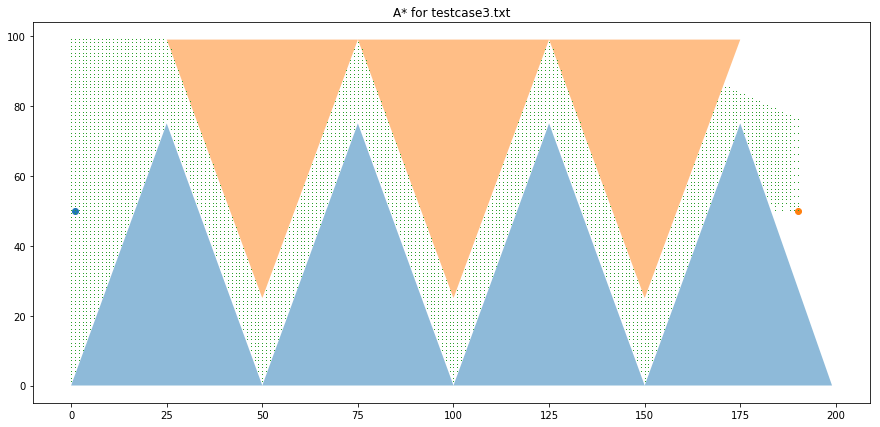

In [19]:
AStarTest("testcase3.txt")

<h2>Test Case 1 - BFS</h2>

<h2>Test Case 1 - DFS</h2>

<h2>Test Case 2 - BFS</h2>

<h2>Test Case 2 - DFS</h2>

<h2>Test Case 3 - BFS </h2>

<h2>Test Case 3 - DFS</h2>

<h1>Analysis</h1>

<h2>Breadth First Search</h2>

<p><strong>Completeness</strong> - As long as a solution exists, breadth first search will always find a solution. For this implementation, the algorithm was able to find a solution for all test cases.</p>

<p><strong>Optimality</strong> - Since the step cost is always one as the path moves to the goal, then this implementation of BFS will always find an optimal solution.</p>

<p><strong>Number of nodes generated</strong> -  As mentioned before, this implementation has a branching factor of 4. In a worst case scenario, the start would be in one corner and the goal in another, then the depth of the created tree would be about 300. That's a total of roughlt 4^300 nodes. Forunately, the space is only a 100x200 grid giving a maximum of 20000 nodes.</p>

<p><strong>Space Complexity</strong> - Not counting arrays created for inputs and outputs (such as the polygon arrays and the path array), the worst case space complexity of the BFS algorithm is also 100x200. Since the program stores parent node coordinates in the child nodes, the generated tree can be created using the 100x200 space. (This is with a worst case scenario where the algorithm expands all nodes).</p>

<p><strong>Time Complexity</strong> - Similar to the space complexity, the worst case time complexity of this program is (100x200)n. That is, at the worst case, it has to expand all 100x200 nodes. (If the space was much larger, the time complexity would also be around 4^300)

<h1>Depth First Search</h1>
<p><strong>Completeness</strong>- As long as a solution exists, the depth first search will always find a solution. For this implementation, the algorithm was able to find a solution for all test cases.</p>

<p><strong>Optimality</strong>- Although the depth first search algorithm can always find a solution, the solution it finds is not always optimal. In Test Cases 1-3, the DFS was able to find a solution by going down one branch of the tree until it found a solution. The result is that all the expanded nodes become part of the path to the goal.</p>

<p><strong>Number of nodes generated</strong>- The DFS can sometimes expand fewer nodes than the BFS. This especially occurs when the goal can be found down the first few branches that the DFS algorithm goes, such as in Test Case 3. This gives the result wherein the path nodes are the same as the expanded nodes. However, most of the time, it expands more nodes than BFS. At the worst case scenario, it is still possible for the DFS to expand almost all nodes. In the case of this specific implementation, this occurs when the goal state is at least two spaces behind the start node (goalPosx = startPosx - 2). This is because the nodes to the left of the expanded node are added to the fringe first (meaning they are expanded last out of the four visited nodes). When this occurs, the DFS can also expand at most 100x200 nodes.</p>

<p><strong>Space Complexity</strong>- The worst case space complexity of DFS for this, is also at 100x200. This is the maximum possible depth of the goal node in this implementation. That is, </p>

<p><strong>Time Complexity</strong>- The worst case time complexity is also 100x200. This occurs, again, when the DFS has to expand all nodes.</p>

<h1>Worst Case Tests</h1>

<h1>No Solution Test</h1>
<p>Additionally, here are some tests for an input with no solution</p>

<h3>BFS - No solution</h3>

<h3>DFS - No solution</h3>